<a href="https://colab.research.google.com/github/ABD-01/Siamese-NN/blob/master/Siamese_ORL_ResNet/Siamese_ORL(ResNet).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import glob
import numpy as np
import random
import matplotlib.pyplot as plt
from PIL import Image
from itertools import combinations 
from collections import OrderedDict
from tqdm import tqdm #, tqdm_notebook
from tqdm.notebook import tqdm as tqdm_notebook
 
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset

import torchvision
import torchvision.transforms as transforms

In [2]:
torch.cuda.is_available()

True

In [3]:
def seed_init():
    np.random.seed(0)
    random.seed(0)
    torch.manual_seed(0)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(0)
        torch.cuda.manual_seed_all(0)
    torch.backends.cudnn.enabled = False
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

# ref : https://discuss.pytorch.org/t/random-seed-initialization/7854/19

In [4]:
seed_init()

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
PATH = '/content/drive/MyDrive/Colab Notebooks/att_face_dataset/'

In [6]:
class CustomDataset(Dataset):

    def __init__(self, path, transform=transforms.ToTensor()):
        self.dirs = glob.glob(f'{path}*/')
        self.transform = transform
        
        self.total_images = self._get_images(self.dirs, self.transform)

    def _get_images(self, dirs, transform):
        ti = []
        for dir in tqdm_notebook(dirs):
#             images = [transform(Image.open(image)).squeeze() for image in glob.glob(f'{dir}*')]
            images = [transform(Image.open(image)) for image in glob.glob(f'{dir}*')]
            ti.append(images)
        return ti
        
    def __len__(self):
        return self.dirs.__len__()
    
    def __getitem__(self,idx):
        return torch.stack(self.total_images[idx], dim=0)
# ref : https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

In [7]:
process = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=0.4422, std=0.1931),
])

# dataset = list(att_dataset)
# torch.cat(dataset).mean() , torch.cat(dataset).std()
# #  (tensor(0.4417), tensor(0.1958))

In [8]:
att_dataset = CustomDataset(PATH, transform=process)

In [9]:
att_dataset[0].shape

torch.Size([10, 1, 224, 224])

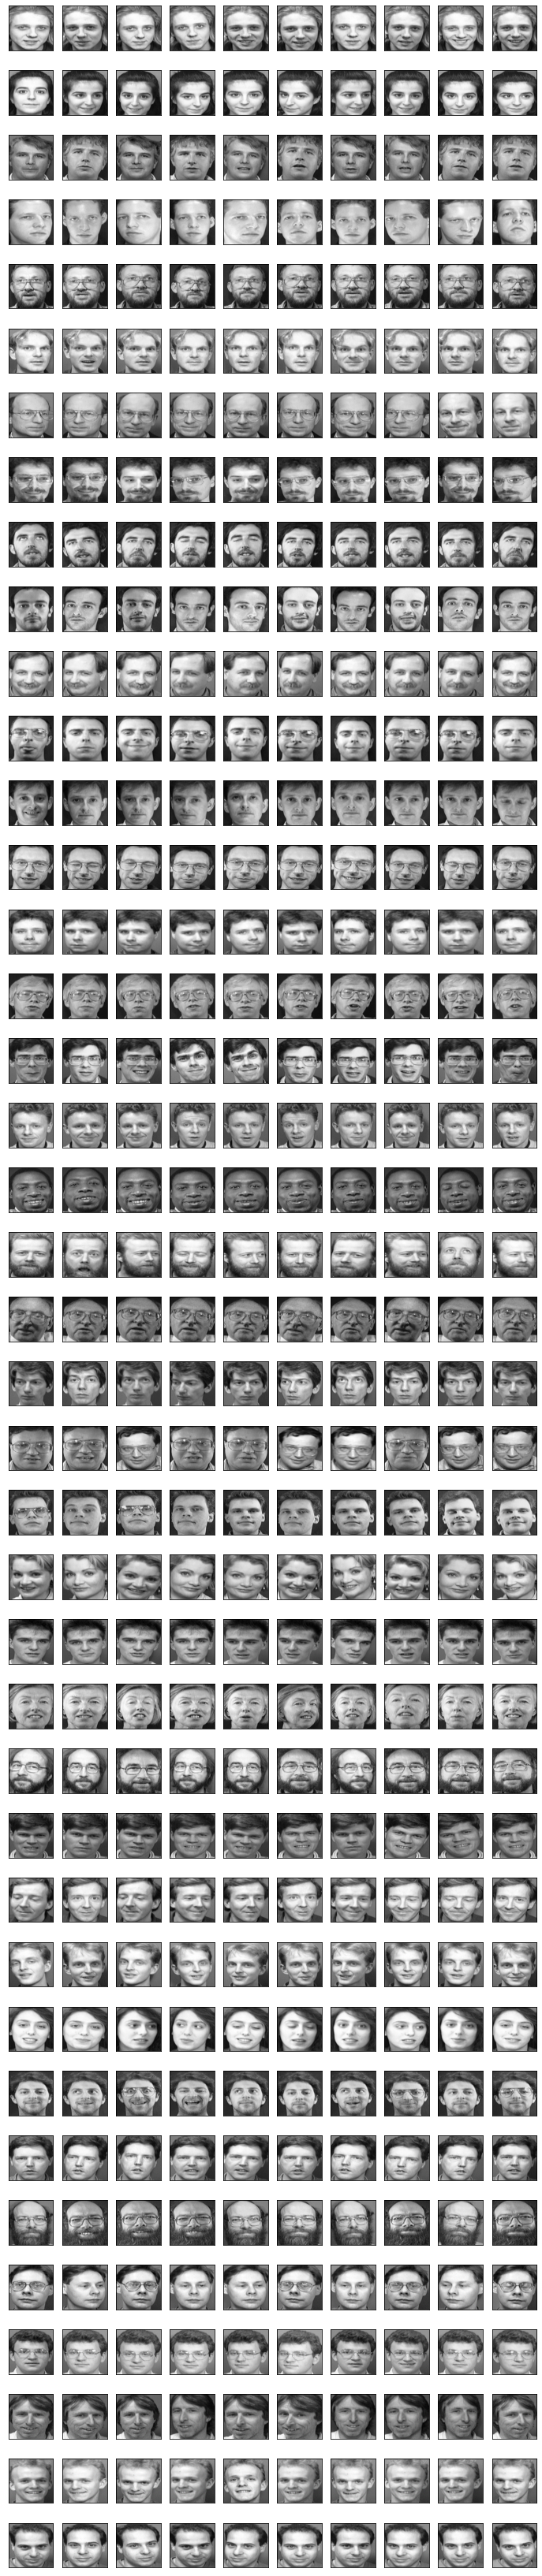

In [ ]:
_,axxr = plt.subplots(40,10, figsize=(12,60))
for i in range(40):
    for j in range(10):
        axxr[i][j].imshow(att_dataset[i][j].squeeze(), cmap='gray')
plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])
# ref : https://stackoverflow.com/questions/25124143/matplotlib-subplots-get-rid-of-tick-labels-altogether
plt.show()

In [ ]:
# 10x40
# 38 x 8 Test 

In [9]:
dataset = list(att_dataset)
torch.cat(dataset).mean() , torch.cat(dataset).std()
#  (tensor(0.4417), tensor(0.1958))

(tensor(-7.0955e-05), tensor(0.9998))

In [10]:
del att_dataset

In [11]:
dataset = torch.stack(dataset)
dataset.shape

torch.Size([40, 10, 1, 224, 224])

In [12]:
train = dataset[0:38, 0:8]
train.shape

torch.Size([38, 8, 1, 224, 224])

In [13]:
test_seen = dataset[0:38, 8:]
test_seen.shape

torch.Size([38, 2, 1, 224, 224])

In [14]:
test_unseen = dataset[38:]
test_unseen.shape

torch.Size([2, 10, 1, 224, 224])

In [15]:
SAMPLE = dataset[:,0,...]
SAMPLE.shape

torch.Size([40, 1, 224, 224])

In [16]:
def triplet_loss(anchor, positive, negative, margin=1):
    pos_dist = (anchor - positive).pow(2).sum(-1) #.pow(.5)
    neg_dist = (anchor - negative).pow(2).sum(-1) #.pow(.5)
    loss = F.relu(pos_dist - neg_dist + margin)
    return loss.mean()
 
# ref: https://github.com/adambielski/siamese-triplet/blob/master/losses.py#L24

In [13]:
def get_random_triplets(embeddings,  targets=None) -> torch.Tensor:
    '''
    For each image in data (Anchor), randomly sample a Positive image from its class.  
    Then from each of the other classes sample one image (randomly) as the Negative. Hence, for every Anchor
    you will have 1 randomly selected positive from it's class and randomly selected Negative from each of the n-1 classes 
    where n is total number of classes.  For every Anchor image you would have n-1 triplets.
    So if you're having 3 classes of 10 images each then you would have 60 triplets. 
    '''


#     assert len(embeddings) == len(targets) , "Embeddings and Targets must have same lenght"

    triplets = []
    for i, embedding in enumerate(embeddings):
        temp = embeddings.pop(i)

        for anchor in embedding:
            positive = random.choice(embedding)

            for negatives in embeddings:
                negative = random.choice(negatives)

                triplets.append(torch.stack([anchor, positive, negative], dim=0))

        embeddings.insert(i, temp)

    return torch.stack(triplets, dim=0)

In [17]:
def get_random_triplets(images) -> torch.Tensor:
    '''
    For each image in data (Anchor), randomly sample a Positive image from its class.  
    Then from each of the other classes sample one image (randomly) as the Negative. Hence, for every Anchor
    you will have 1 randomly selected positive from it's class and randomly selected Negative from each of the n-1 classes 
    where n is total number of classes.  For every Anchor image you would have n-1 triplets.
    So if you're having 3 classes of 10 images each then you would have 60 triplets. 
    '''
    assert len(images.shape) == 5, "Shape of input tensor must be [num_cls, num_imgs, n_C, H, W]"
    randomstate = np.random.RandomState(seed=0)

    triplets = []
    num_cls, num_imgs = images.shape[0:2]
    for anc_cls in tqdm_notebook(range(num_cls)):
        for ianc in range(num_imgs):
            ipos = randomstate.randint(0, num_imgs)
            while ianc == ipos:
                ipos = randomstate.randint(0, num_imgs)

            for neg_cls in range(num_cls):
                if anc_cls == neg_cls:
                    continue
                ineg = randomstate.randint(0, num_imgs)
                triplets.append([anc_cls, ianc, ipos, neg_cls, ineg])
    
    triplets = np.array(triplets)
    anchor   = images[triplets[:,0], triplets[:,1],...]
    positive = images[triplets[:,0], triplets[:,2],...]
    negative = images[triplets[:,3], triplets[:,4],...]

    return  TensorDataset(anchor, positive, negative)
    # return torch.stack([anchor, positive, negative], dim=0)

In [18]:
def dist(enc1,enc2):
    return (enc1 - enc2).pow(2).sum(-1) #.pow(.5)

In [20]:
triplets = get_random_triplets(train)

In [31]:
type(triplets), len(triplets)

(torch.utils.data.dataset.TensorDataset, 11248)

In [27]:
dataset = torch.utils.data.TensorDataset(*triplets)

In [24]:
loader = DataLoader(triplets, batch_size=100, shuffle=True)

In [25]:
sample = next(iter(loader))
len(sample) , sample[0].shape, sample[1].shape, sample[2].shape

(3,
 torch.Size([100, 1, 224, 224]),
 torch.Size([100, 1, 224, 224]),
 torch.Size([100, 1, 224, 224]))

In [34]:
type(sample), len(sample)

(list, 3)

In [35]:
sample[0].shape

torch.Size([100, 1, 224, 224])

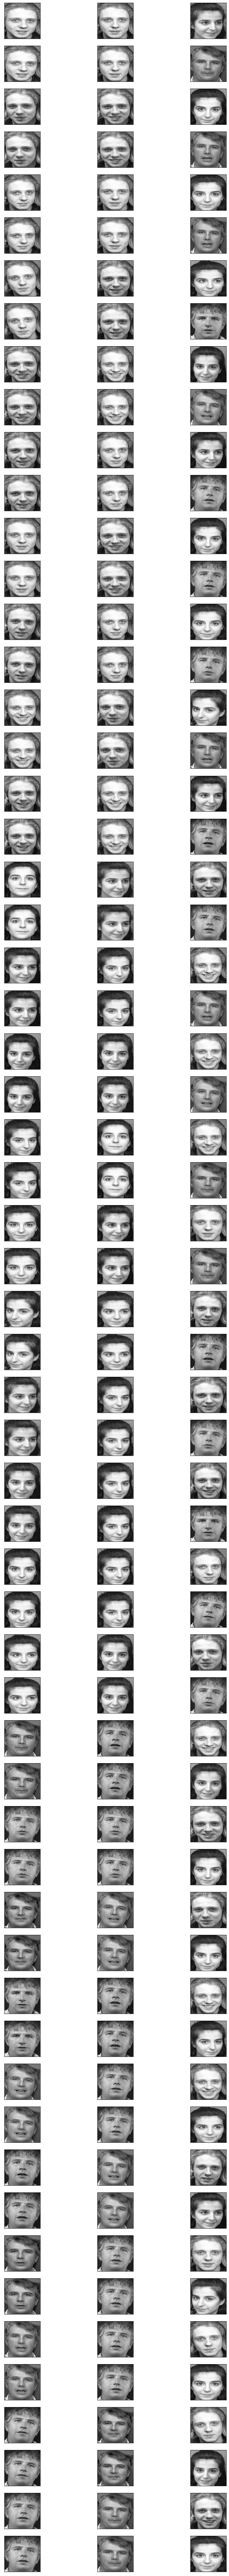

In [ ]:
_,axxr = plt.subplots(60,3, figsize=(12,120))
for i in range(60):
    for j in range(3):
        axxr[i][j].imshow(triplets[i][j].squeeze(), cmap='gray')
plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])
# ref : https://stackoverflow.com/questions/25124143/matplotlib-subplots-get-rid-of-tick-labels-altogether
plt.show()

In [ ]:
class IdentityBlock(nn.Module):

    def __init__(self, n :int):
        super(IdentityBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=n, out_channels=n, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(num_features=n)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(in_channels=n, out_channels=n, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(num_features=n)

    def forward(self, x):
        x_shortcut = x

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)

        x = x + x_shortcut
        x = self.relu(x)

        return x

# Ref : https://github.com/ABD-01/MNIST/blob/DL-Coursera/Course%204%20Convolutional%20Neural%20Network/Week%202%20ResNets/Residual_Networks_v2a.ipynb
# Ref : https://github.com/pytorch/vision/blob/master/torchvision/models/resnet.py#L37

In [ ]:
class ConvolutionalBlock(nn.Module):

    def __init__(self, n_in :int , n_out :int ):
        super(ConvolutionalBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=n_in, out_channels=n_out, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(num_features=n_out)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(in_channels=n_out, out_channels=n_out, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(num_features=n_out)

        self.downsample = nn.Sequential(OrderedDict([
            ('conv', nn.Conv2d(in_channels=n_in, out_channels=n_out, kernel_size=1, stride=2, padding=0, bias=False)),
            ('bn', nn.BatchNorm2d(num_features=n_out))
        ]))


    def forward(self, x):
        x_shortcut = x

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)

        x_shortcut = self.downsample(x_shortcut)

        x = x + x_shortcut
        x = self.relu(x)

        return x

# Ref : https://github.com/ABD-01/MNIST/blob/DL-Coursera/Course%204%20Convolutional%20Neural%20Network/Week%202%20ResNets/Residual_Networks_v2a.ipynb
# From the paper we can see that there are 2 options for matching the output size. Either padding the input volume or perform 1x1 convolutions. 
# Ref : https://towardsdatascience.com/understanding-and-visualizing-resnets-442284831be8

In [19]:
class ResidualBlock(nn.Module):
    
    def __init__(self, n_in :int , n_out :int , stride :int = 1, use_1x1conv=False):
        super(ResidualBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=n_in, out_channels=n_out, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(num_features=n_out)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(in_channels=n_out, out_channels=n_out, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(num_features=n_out)

        if use_1x1conv:
            self.downsample = nn.Sequential(OrderedDict([
                ('conv', nn.Conv2d(in_channels=n_in, out_channels=n_out, kernel_size=1, stride=stride, padding=0, bias=False)),
                ('bn', nn.BatchNorm2d(num_features=n_out))
            ]))
        else:
            self.downsample = None


    def forward(self, x):
        x_shortcut = x

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)

        if self.downsample:
            x_shortcut = self.downsample(x_shortcut)

        x = x + x_shortcut
        x = self.relu(x)

        return x

# ref : https://d2l.ai/chapter_convolutional-modern/resnet.html
# ref : https://github.com/pytorch/vision/blob/master/torchvision/models/resnet.py#L144

In [20]:
class ResNet(nn.Module):

    def __init__(self, layers = [2,2,2,2]):
        # resnet18 : layers = [2, 2, 2, 2]
        # resnet34 : layers = [3, 4, 6, 3]
        super(ResNet, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(num_features=64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = nn.Sequential(
            self._make_layer(in_channels = 64, out_channels = 64, num_residuals = layers[0])                                 
        )
                            
        self.layer2 = nn.Sequential(
            self._make_layer(in_channels = 64, out_channels = 128, num_residuals = layers[1], reduce_dim = True) 
         )

        self.layer3 = nn.Sequential(
            self._make_layer(in_channels = 128, out_channels = 256, num_residuals = layers[2], reduce_dim = True) 
        )
                            
        self.layer4 = nn.Sequential(
            self._make_layer(in_channels = 256, out_channels = 512, num_residuals = layers[3], reduce_dim = True) 
        )
            
        self.avgpool = nn.AvgPool2d(kernel_size=7)
        # self.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))
        self.fc = nn.Sequential(
            nn.Linear(in_features=512*1, out_features=128),
            nn.ReLU(inplace=True)
        )

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')

    def _make_layer(self, in_channels:int, out_channels:int, num_residuals: int, reduce_dim = False):
        block_layers = []
        for i in range(num_residuals):
            if i == 0 and reduce_dim:
                block_layers.append((f'block{i+1}', ResidualBlock(n_in = in_channels, n_out = out_channels, stride=2, use_1x1conv = True)))
            else:
                block_layers.append((f'block{i+1}', ResidualBlock(n_in = out_channels, n_out = out_channels)))

        return OrderedDict( block_layers )
    
    # ref : https://d2l.ai/chapter_convolutional-modern/resnet.html


    def semi_forward(self, x):

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(input=x, start_dim=1) # ref : https://pytorch.org/docs/stable/generated/torch.flatten.html
        x = self.fc(x)
        return x

    def forward(self,triplet):
        # anc = self.semi_forward(triplet[:,0,...])
        # pos = self.semi_forward(triplet[:,1,...])
        # neg = self.semi_forward(triplet[:,2,...])
        
        # batch_size = triplet.shape[0]
        # # triplet = triplet.view(triplet.shape[0]*triplet.shape[1], triplet.shape[2], triplet.shape[3],triplet.shape[4])
        # triplet = triplet.view(triplet.shape[0]*triplet.shape[1], *triplet.shape[2:])
        # out = self.semi_forward(triplet)
        # out = out.view(batch_size,3, *out.shape[1:])
        # return torch.unbind(out,dim=1)

        out = self.semi_forward(triplet)
        return out

# ref : https://towardsdatascience.com/understanding-and-visualizing-resnets-442284831be8

In [ ]:
class ResNet18(nn.Module):

    def __init__(self):
        super(ResNet18, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(num_features=64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = nn.Sequential(OrderedDict([
            ('block1', IdentityBlock(n = 64)),
            ('block2', IdentityBlock(n = 64))
        ]))
                            
        self.layer2 = nn.Sequential(OrderedDict([
            ('block1', ConvolutionalBlock(n_in = 64, n_out = 128)),
            ('block2', IdentityBlock(n = 128))
        ]))

        self.layer3 = nn.Sequential(OrderedDict([
            ('block1', ConvolutionalBlock(n_in = 128, n_out = 256)),
            ('block2', IdentityBlock(n = 256))
        ]))
                            
        self.layer4 = nn.Sequential(OrderedDict([
            ('block1', ConvolutionalBlock(n_in = 256, n_out = 512)),
            ('block2', IdentityBlock(n = 512))
        ]))
            
        self.avgpool = nn.AvgPool2d(kernel_size=7)
        # self.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))
        self.fc = nn.Sequential(
            nn.Linear(in_features=512*1, out_features=128),
            nn.ReLU(inplace=True)
        )

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')

    def semi_forward(self, x):

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(input=x, start_dim=1) # ref : https://pytorch.org/docs/stable/generated/torch.flatten.html
        x = self.fc(x)
        return x

    def forward(self,triplet):
        anc = self.semi_forward(triplet[:,0,...])
        pos = self.semi_forward(triplet[:,1,...])
        neg = self.semi_forward(triplet[:,2,...])
        return [anc, pos, neg]

# ref : https://towardsdatascience.com/understanding-and-visualizing-resnets-442284831be8

In [ ]:
class RESNET18(nn.Module):
    def __init__(self):
        super(RESNET18, self).__init__()

        self.model = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=3, kernel_size=1, stride=1, padding=0, bias=False),
            torchvision.models.resnet18(pretrained=False),
            nn.Linear(1000, 128)
        )
    def semi_forward(self, x):
        return self.model(x)

    def forward(self,triplet):
        anc = self.semi_forward(triplet[:,0,...])
        pos = self.semi_forward(triplet[:,1,...])
        neg = self.semi_forward(triplet[:,2,...])
        return [anc, pos, neg] 

In [21]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [70]:
torch.cat(batch).shape

torch.Size([300, 1, 224, 224])

In [26]:
t = torch.rand(300,1,224,224)
t1 = resnet18(t)

In [22]:
def Train(model, batch, loss_fn, optimizer, cost, device='cuda'):

    # batch_size = batch.shape[0]
    batch_size = batch[0].shape[0]
    assert batch[0].shape[0] == batch[1].shape[0] == batch[2].shape[0]
    # three = batch.shape[1]
    # assert three == 3
    three = 3

    # batch = batch.view(batch_size*three, *batch.shape[2:])
    batch = torch.cat(batch)

    embeddings = model(batch.to(device))
    embeddings = embeddings.view(batch_size, three, *embeddings.shape[1:])
    anc_embeddings, pos_embeddings, neg_embeddings = torch.unbind(embeddings, dim=1)

    optimizer.zero_grad()
    loss = loss_fn(anc_embeddings, pos_embeddings, neg_embeddings)
    cost.append(loss.item())
    loss.backward()
    optimizer.step()

    return loss.item()

In [23]:
def Evaluate(model, batch, device='cuda'):
    assert len(images.shape) == 5, "Shape of input tensor must be [num_cls, num_imgs, n_C, H, W]"
    model.eval()

    with torch.no_grad():
        sample_enc = model(SAMPLE.to(device))
        
        num_cls, num_imgs = images.shape[0:2]
        batch = batch.view(num_cls*num_imgs, *batch.shape[2:])
        embeddings = model(batch.to(device))
        embeddings = embeddings.view(num_cls, num_imgs, *embeddings.shape[1:])


        pred = [torch.stack([dist(enc,sample).argmin() for enc in total_enc[i]]) for i in range(len(total_enc))]
        # acc = sum([(pred[i] == i).sum() for i in range(len(total_enc))])
        del total_enc
    # return (acc.item() / (len(batch) * 10) )
    return torch.stack(pred)

In [42]:
resnet18 = ResNet([2,2,2,2])

In [25]:
count_parameters(resnet18)

11235904

In [57]:
learning_rate = 0.0001
optimizer18 = optim.Adam(resnet18.parameters(), lr = learning_rate)
torch_triplet_loss = nn.TripletMarginLoss()
if torch.cuda.is_available():
    resnet18.cuda()

In [58]:
# stepwise_cost = []
# epoch_cost = []
epochs = 20
resnet18.train()
for epoch in range(epochs):

    if epoch % 4 == 0:
        triplets = get_random_triplets(train[0:10, ...])
    elif epoch % 4 == 1:
        triplets = get_random_triplets(train[10:20, ...])
    elif epoch % 4 == 2:
        triplets = get_random_triplets(train[20:30, ...])
    else:
        triplets = get_random_triplets(train[30:, ...])
    print('Lenght of Triplets Dataset is',len(triplets))
    loader = DataLoader(triplets, batch_size=72, shuffle=True)
    steps = len(loader)
    cost = []
    for i,batch in enumerate(loader):

        loss = Train(resnet18, batch, triplet_loss, optimizer18, cost)

        if i%5 == 0 :
            print(f'Epoch:[{epoch+1}/{epochs}], Step:[{i+1}/{steps}]', 'Cost : {:.2f}'.format(loss))
            # print(f'Epoch:[{epoch+1}/{epochs}], Step:[{i+1}] Cost : {loss.item()}')
    epoch_cost.append(sum(cost)/steps)
    stepwise_cost.extend(cost)
    print(f"Epoch {epoch+1} Loss : {epoch_cost[-1]}")
    del triplets


Lenght of Triplets Dataset is 720


RuntimeError: ignored

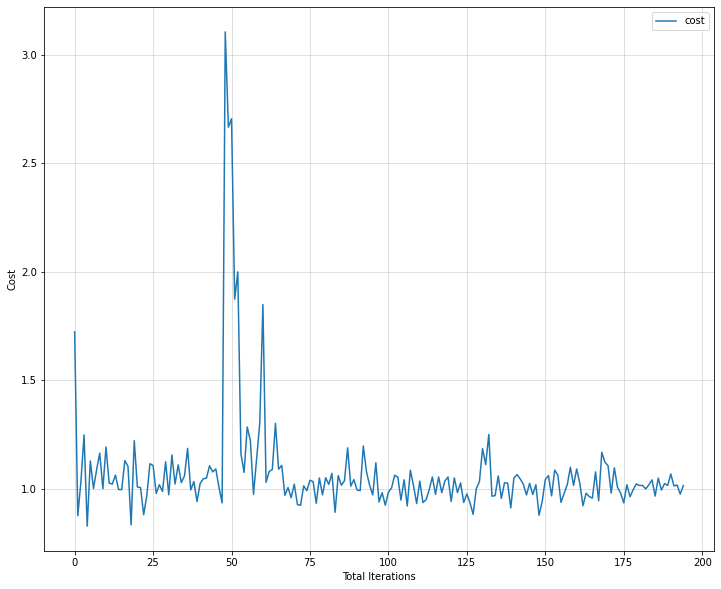

In [61]:
plt.figure(figsize=(12,10))
plt.xlabel('Total Iterations')
plt.ylabel('Cost')
plt.plot(np.arange(len(stepwise_cost)), stepwise_cost, label='cost')
# plt.plot(np.arange(len(epoch_cost)), epoch_cost, label='Epoch cost')
plt.grid(alpha=0.5)
plt.legend()
# plt.savefig('/content/drive/MyDrive/Colab Notebooks/siamese-orl-loss on 30classes(resnet18vs26)')
plt.show()

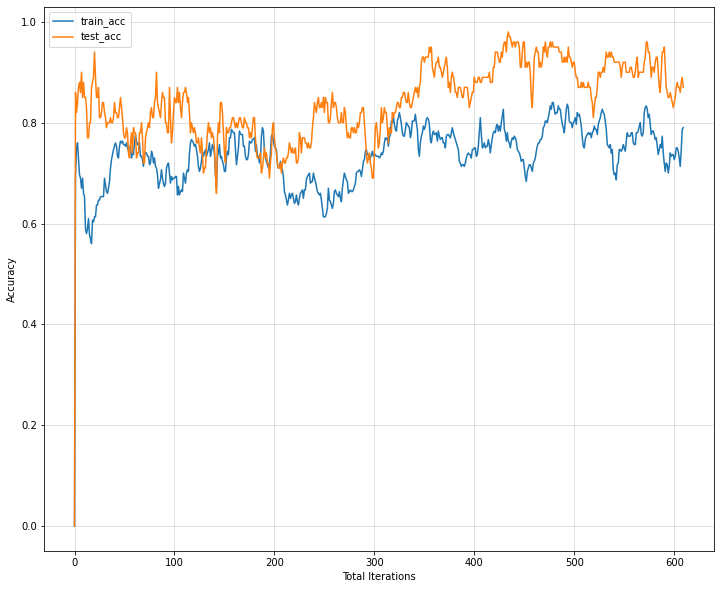

In [ ]:
plt.figure(figsize=(12,10))
plt.xlabel('Total Iterations')
plt.ylabel('Accuracy')
plt.plot(np.arange(len(train_acc)), train_acc, label='train_acc')
plt.plot(np.arange(len(test_acc)), test_acc, label='test_acc')
plt.grid(alpha=0.5)
plt.legend()
# plt.savefig('/content/drive/MyDrive/Colab Notebooks/siamese-orl-loss on 30classes(resnet)')
plt.show()

In [ ]:
torch.set_grad_enabled(False)
resnet18.train(False)
resnet26.train(False)

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (block1): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (block2): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(

In [ ]:
resnet18.eval()

In [59]:
test_seen.shape, train.shape[2:]

(torch.Size([38, 2, 1, 224, 224]), 1, 224, 224)

In [66]:
resnet18.cpu()
sample = resnet18(SAMPLE[:38].to('cpu'))

In [68]:
def evaluate(model, images):
    with torch.no_grad():
        
        num_cls, num_imgs = images.shape[0:2]
        images = images.reshape(num_cls*num_imgs, 1,224,224)
        embeddings = model(images.to("cpu"))
        embeddings = embeddings.view(num_cls, num_imgs, *embeddings.shape[1:])

        return embeddings


In [69]:
seen_emd = evaluate(resnet18, test_seen)
seen_emd.shape

torch.Size([38, 2, 128])

In [70]:
seen_dist = dist(sample.unsqueeze(1).unsqueeze(1), seen_emd)
seen_dist.shape

torch.Size([38, 38, 2])

In [71]:
preds = seen_dist.argmin(0)

In [72]:
preds

tensor([[ 0,  3],
        [ 1,  1],
        [15, 15],
        [ 3, 29],
        [17,  4],
        [ 9,  9],
        [ 6,  1],
        [ 7,  7],
        [13, 21],
        [ 9,  9],
        [10, 10],
        [15, 15],
        [ 7, 12],
        [28, 13],
        [14, 14],
        [15, 15],
        [16, 16],
        [27, 29],
        [19,  2],
        [30, 19],
        [23, 23],
        [ 0,  0],
        [29, 28],
        [14, 14],
        [24, 24],
        [13, 24],
        [19, 16],
        [13, 22],
        [13, 28],
        [29, 32],
        [30, 30],
        [31, 31],
        [34, 22],
        [13, 29],
        [12, 34],
        [35, 36],
        [ 1,  1],
        [37, 37]])

Actual Class: 36
Predicted Class: tensor(37, device='cuda:0')


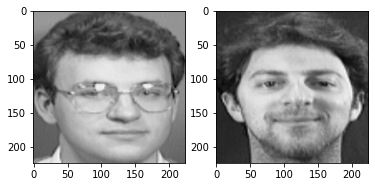

In [75]:
Class = 36
_,(i1,i2) = plt.subplots(1,2)
randImg = test_seen[Class][1]
i1.imshow(randImg.squeeze(), cmap='gray')
renc = resnet18.semi_forward(randImg.unsqueeze(0).cuda())#.cpu()
dis = dist(renc, sample)
print('Actual Class:', Class)
print('Predicted Class:',dis.argmin())
i2.imshow(SAMPLE[dis.argmin().item()].squeeze(), cmap='gray')
plt.show()

In [ ]:
total_enc = [resnet18.semi_forward(img.cuda()).cpu() for img in tqdm(dataset)]

100%|██████████| 40/40 [00:00<00:00, 41.83it/s]


In [ ]:
pred = [torch.stack([dist(enc,sample).argmin() for enc in total_enc[i]]) for i in range(40)]
print(*pred, sep='\n')

In [ ]:
sum([(pred[i] == i).sum() for i in range(len(pred))]) / (len(pred) * 10) 

tensor(0.8700)

In [ ]:
test_pred = Evaluate(resnet18, test)
test_acc = ( (test_pred == torch.arange(len(test_pred)).reshape(-1,1)).sum() / (len(test_pred)*10) ).item()

train_pred = Evaluate(resnet18, train)
train_acc = ( (train_pred == torch.arange(len(train_pred)).reshape(-1,1)).sum() / (len(train_pred)*10) ).item()

total_pred = Evaluate(resnet18, dataset)
total_acc = ( (total_pred == torch.arange(len(total_pred)).reshape(-1,1)).sum() / (len(total_pred)*10) ).item()

# test_pred = Evaluate(resnet26, test)
# test_acc = ( (test_pred == torch.arange(len(test_pred)).reshape(-1,1)).sum() / (len(test_pred)*10) ).item()

# train_pred = Evaluate(resnet26, train)
# train_acc = ( (train_pred == torch.arange(len(train_pred)).reshape(-1,1)).sum() / (len(train_pred)*10) ).item()

# total_pred = Evaluate(resnet26, dataset)
# total_acc = ( (total_pred == torch.arange(len(total_pred)).reshape(-1,1)).sum() / (len(total_pred)*10) ).item()

In [ ]:
print('Train Acc: {:.2f}\nTest Acc: {:.2f}\nTotal Acc: {:.2f}'.format(train_acc, test_acc, total_acc))

Train Acc: 0.98
Test Acc: 0.87
Total Acc: 0.89


In [ ]:
torch.arange(len(torch.stack(pred))).reshape(-1,1)

tensor([[0],
        [1],
        [2],
        [3],
        [4],
        [5],
        [6],
        [7],
        [8],
        [9]])

In [ ]:
test_pred

tensor([[0, 8, 0, 0, 8, 8, 0, 0, 0, 8],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
        [3, 3, 9, 3, 3, 3, 3, 3, 3, 3],
        [4, 5, 5, 5, 4, 4, 4, 5, 4, 5],
        [5, 9, 5, 9, 9, 5, 5, 5, 5, 5],
        [6, 6, 6, 6, 6, 6, 6, 6, 6, 6],
        [7, 7, 7, 7, 7, 7, 7, 7, 7, 7],
        [8, 8, 8, 8, 8, 8, 8, 8, 8, 8],
        [9, 9, 9, 9, 9, 9, 9, 9, 9, 9]])

In [ ]:
train_pred

tensor([[ 0, 29,  0,  0,  0,  3,  0,  3,  0,  0],
        [ 1, 12,  9,  9,  1, 12, 12,  9,  9,  9],
        [ 2, 15,  2, 15,  2, 15,  2,  2, 15, 15],
        [ 3,  6,  0,  3,  3,  6,  7,  6,  6,  3],
        [ 4,  4,  4,  4,  4,  4,  4,  4,  4,  4],
        [ 5,  5,  5,  0, 19,  5, 19, 19, 19, 19],
        [ 6,  6, 19,  6, 19,  6,  5,  6, 19, 19],
        [ 7,  7, 14,  7, 14,  7,  7,  7,  7,  7],
        [ 8,  8,  8,  8,  8,  8,  8,  8,  8,  8],
        [ 9, 13,  8,  9,  7,  8, 22,  8,  9, 12],
        [10, 10, 10, 29, 10, 10, 10, 29, 10, 10],
        [11,  3, 11, 11, 11, 11,  7, 11, 11,  3],
        [12, 16, 12, 25, 25, 25, 12, 12, 12, 28],
        [13, 13, 13,  8, 13, 13, 13, 13, 13, 13],
        [14, 14, 21, 21, 14, 21, 14, 14, 14, 14],
        [15, 15, 15, 15, 26, 15, 15, 15, 15, 15],
        [16, 23, 16, 25,  7, 23, 23, 22, 16, 16],
        [17, 25, 17, 17, 17, 17, 25, 21, 17, 17],
        [18, 18, 18, 18, 18, 12, 12, 18, 18, 18],
        [19, 19, 19, 19,  0, 19, 19, 19, 19, 19],


In [ ]:
total_pred

tensor([[ 0, 29,  0,  0,  0,  3,  0,  3,  0,  0],
        [ 1, 12,  9,  9,  1, 12, 12,  9,  9,  9],
        [ 2, 15,  2, 15,  2, 15,  2,  2, 15, 15],
        [ 3,  6,  0,  3,  3,  6,  7,  6,  6,  3],
        [ 4,  4,  4,  4,  4,  4,  4,  4,  4,  4],
        [ 5,  5,  5,  0, 19,  5, 19, 19, 19, 19],
        [ 6,  6, 19,  6, 19,  6,  5,  6, 19, 19],
        [ 7,  7, 14,  7, 14,  7,  7,  7,  7,  7],
        [ 8,  8,  8,  8,  8,  8,  8,  8,  8,  8],
        [ 9, 13,  8,  9,  7,  8, 22,  8,  9, 12],
        [10, 10, 10, 29, 10, 10, 10, 29, 10, 10],
        [11,  3, 11, 11, 11, 11,  7, 11, 11,  3],
        [12, 16, 12, 25, 25, 25, 12, 12, 12, 28],
        [13, 13, 13,  8, 13, 13, 13, 13, 13, 13],
        [14, 14, 21, 21, 14, 21, 14, 14, 14, 14],
        [15, 15, 15, 15, 26, 15, 15, 15, 15, 15],
        [16, 23, 16, 25,  7, 23, 23, 22, 16, 16],
        [17, 25, 17, 17, 17, 17, 25, 21, 17, 17],
        [18, 18, 18, 18, 18, 12, 12, 18, 18, 18],
        [19, 19, 19, 19,  0, 19, 19, 19, 19, 19],


In [ ]:
acc = []
pred = total_pred
for i in range(len(pred)):
    corr = (pred[i] == i).sum()
    print(f'(Claas {i})', corr.item(), 'out of 10')
    acc.append(corr.item())

print('Train Accuracy = ', sum(acc[:30])/3, '%')
print('Test Accuracy = ', sum(acc[30:])/1, '%')
print('Total Accuracy = ', sum(acc)/4, '%')
print('Accuracy = ', sum(acc) / (len(pred)*10))


#@markdown Train Accuracy =82.0 %   

#@markdown Test Accuracy =  87.0 %  

#@markdown Total Accuracy =  88.0 %  





(Claas 0) 10 out of 10
(Claas 1) 10 out of 10
(Claas 2) 10 out of 10
(Claas 3) 5 out of 10
(Claas 4) 10 out of 10
(Claas 5) 9 out of 10
(Claas 6) 8 out of 10
(Claas 7) 5 out of 10
(Claas 8) 10 out of 10
(Claas 9) 8 out of 10
(Claas 10) 9 out of 10
(Claas 11) 10 out of 10
(Claas 12) 9 out of 10
(Claas 13) 10 out of 10
(Claas 14) 10 out of 10
(Claas 15) 10 out of 10
(Claas 16) 10 out of 10
(Claas 17) 6 out of 10
(Claas 18) 10 out of 10
(Claas 19) 6 out of 10
(Claas 20) 2 out of 10
(Claas 21) 5 out of 10
(Claas 22) 7 out of 10
(Claas 23) 3 out of 10
(Claas 24) 4 out of 10
(Claas 25) 5 out of 10
(Claas 26) 9 out of 10
(Claas 27) 6 out of 10
(Claas 28) 10 out of 10
(Claas 29) 4 out of 10
(Claas 30) 4 out of 10
(Claas 31) 10 out of 10
(Claas 32) 10 out of 10
(Claas 33) 6 out of 10
(Claas 34) 5 out of 10
(Claas 35) 8 out of 10
(Claas 36) 10 out of 10
(Claas 37) 6 out of 10
(Claas 38) 5 out of 10
(Claas 39) 8 out of 10
Train Accuracy =  76.66666666666667 %
Test Accuracy =  72.0 %
Total Accurac

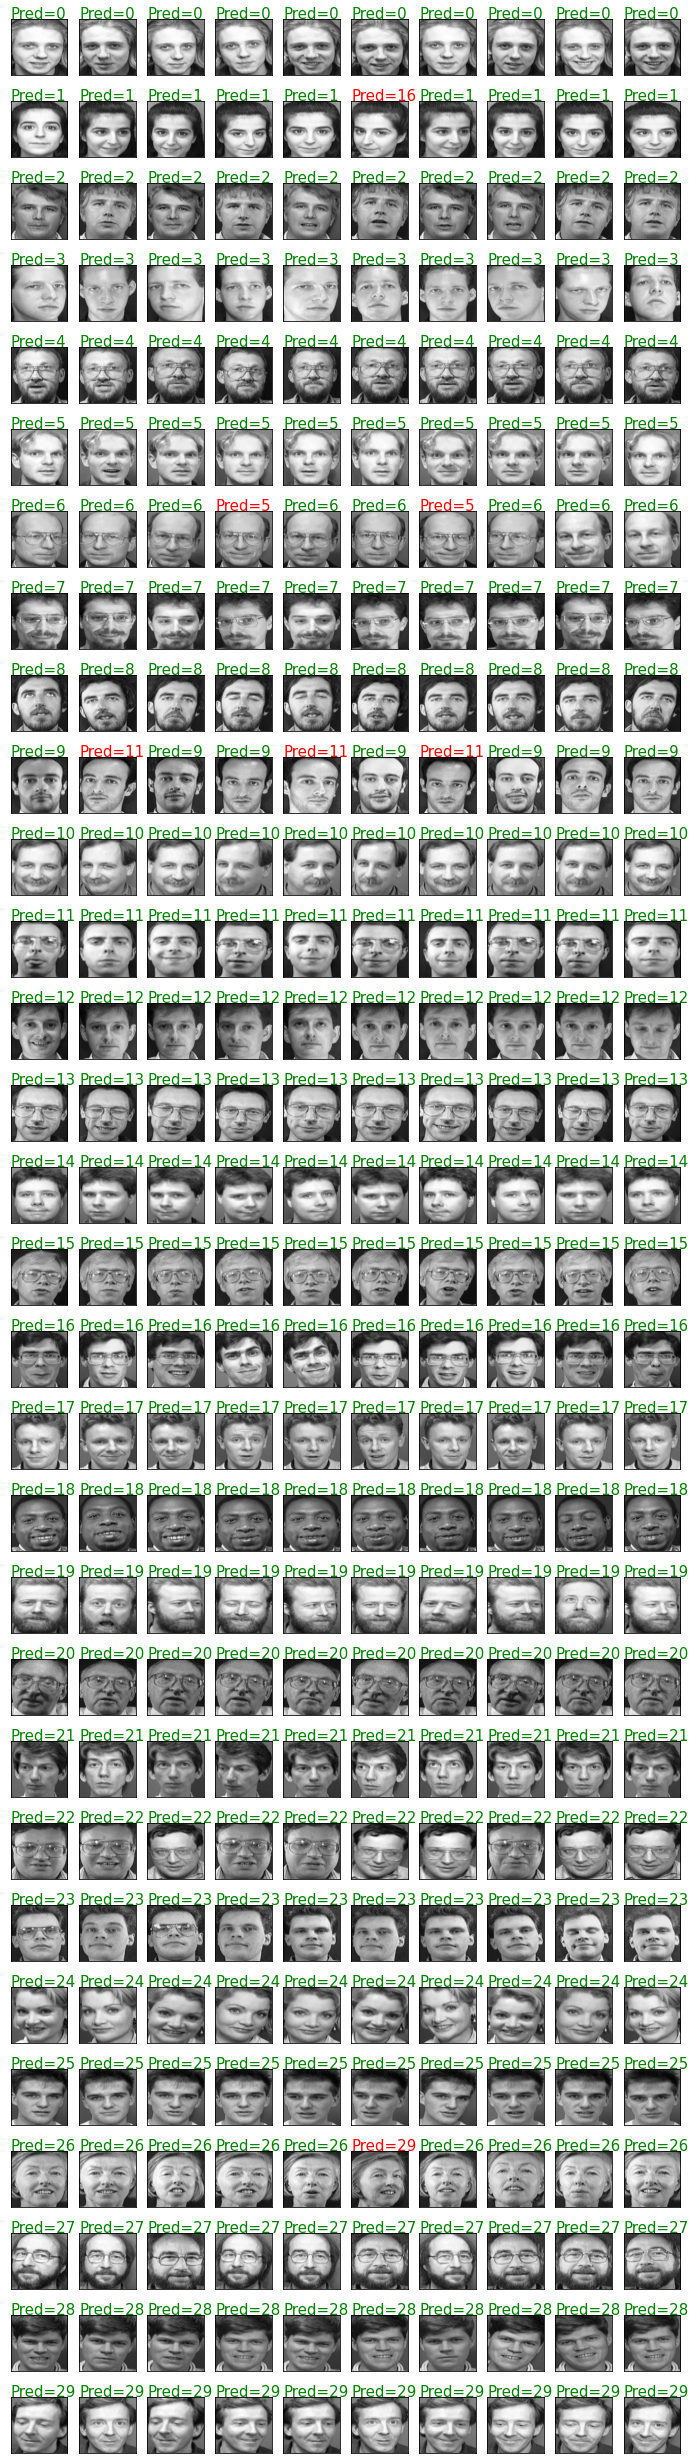

In [ ]:
_,axxr = plt.subplots(len(train_pred),10, figsize=(12,len(train_pred)*1.5))
for i in range(len(train_pred)):
    for j in range(10):
        axxr[i][j].imshow(train[i][j].squeeze(), cmap='gray')
        if train_pred[i][j] == i:
            axxr[i][j].text(0.5,1,f'Pred={i}', color='green', fontsize=15)
        else:
            axxr[i][j].text(0.5,1,f'Pred={train_pred[i][j].item()}', color='red', fontsize=15)
plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])
# ref : https://stackoverflow.com/questions/25124143/matplotlib-subplots-get-rid-of-tick-labels-altogether
# plt.savefig('/content/drive/MyDrive/Colab Notebooks/prediction_results of all 40 classes(resnet).png', dpi=200)
plt.show()

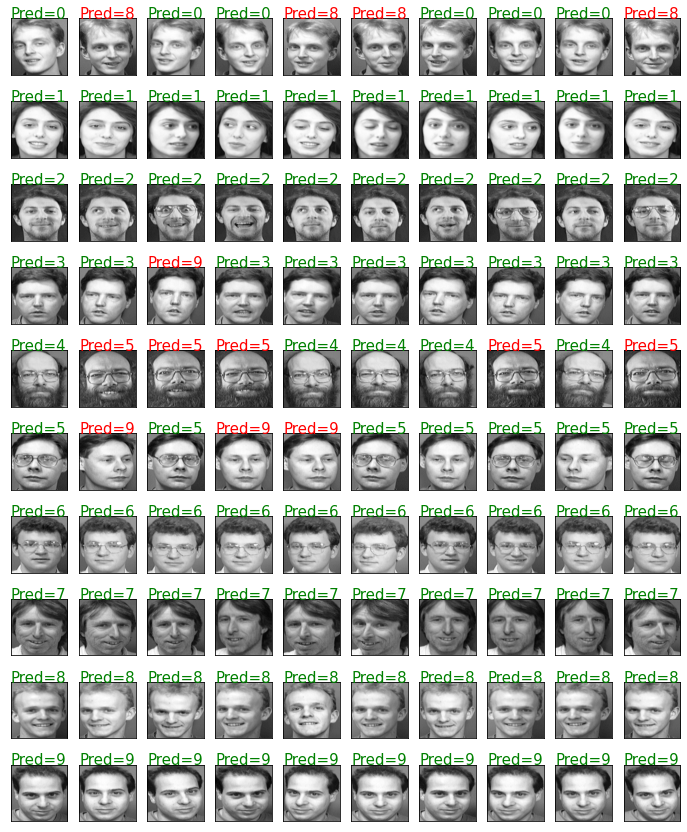

In [ ]:
_,axxr = plt.subplots(len(test_pred),10, figsize=(12,len(test_pred)*1.5))
for i in range(len(test_pred)):
    for j in range(10):
        axxr[i][j].imshow(test[i][j].squeeze(), cmap='gray')
        if test_pred[i][j] == i:
            axxr[i][j].text(0.5,1,f'Pred={i}', color='green', fontsize=15)
        else:
            axxr[i][j].text(0.5,1,f'Pred={test_pred[i][j].item()}', color='red', fontsize=15)
plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])
# ref : https://stackoverflow.com/questions/25124143/matplotlib-subplots-get-rid-of-tick-labels-altogether
# plt.savefig('/content/drive/MyDrive/Colab Notebooks/prediction_results of all 40 classes(resnet).png', dpi=200)
plt.show()

In [38]:
# Saving the state_dict of Model
PATH = '/content/drive/MyDrive/Colab Notebooks/siamese-orl(resnet)8.pth'

In [39]:
torch.save(resnet18.state_dict(), PATH)

In [ ]:
# resnet18.load_state_dict(torch.load(PATH,  map_location=torch.device('cpu')))
resnet18.load_state_dict(torch.load(PATH))
resnet18.eval()

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (block1): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (block2): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(

# Testing Stuff

In [ ]:
randomstate = np.random.RandomState(seed=0)

In [ ]:
a = randomstate.randint(0, 7)
b = randomstate.randint(0, 7)
while a==b:
    b = randomstate.randint(0, 7)
a,b

In [ ]:
num_cls = 3
num_imgs = 10

In [ ]:
triplets = []
for anc_cls in range(num_cls):
    for ianc in range(num_imgs):
        ipos = randomstate.randint(0, num_imgs)
        while ianc == ipos:
            ipos = randomstate.randint(0, num_imgs)
        
        for neg_cls in range(num_cls):
            if anc_cls == neg_cls:
                continue
            ineg = randomstate.randint(0, num_imgs)
            triplets.append([anc_cls, ianc, ipos, neg_cls, ineg])

In [ ]:
triplets = np.array(triplets)
triplets

In [ ]:
triplets[:,1]

In [ ]:
len(triplets)

In [ ]:
triplets.shape

In [ ]:
t1 = torch.arange(num_cls* num_imgs*224*224).reshape(num_cls, num_imgs, 1,224,224)
t1.shape

In [ ]:
anchors = t1[triplets[:,0], triplets[:,1],...]
anchors.shape

In [ ]:
positive = t1[triplets[:,0], triplets[:,2],...]
positive.shape

In [ ]:
negative = t1[triplets[:,3], triplets[:,4],...]
negative.shapetorch.sum(anchors == anchors)

In [ ]:
(anchors == positive).sum()

In [ ]:
resnet18 = ResNet()
resnet18.eval()
t1 = torch.rand(10,1,224,224)
t2 = torch.rand(10,1,224,224)
t3 = torch.rand(10,1,224,224)
print('rand', t1.shape)
t = resnet18.conv1(t1)
print('conv1', t.shape)
t = resnet18.maxpool(t)
print('maxpool', t.shape)
t = resnet18.layer1(t)
print('layer1', t.shape)
t = resnet18.layer2(t)
print('layer2', t.shape)
t = resnet18.layer3(t)
print('layer3', t.shape)
t = resnet18.layer4(t)
print('layer4', t.shape)
t = resnet18.avgpool(t)
print('avgpool', t.shape)
t = torch.flatten(t,1)
print('flatten', t.shape)
t = resnet18.fc(t)
print('fc', t.shape)

t = resnet18.semi_forward(t1)
print('semi', t.shape)

ts = torch.stack([t1,t2,t3],dim=1)
print('rand', ts.shape)
t_ = resnet18(ts)
print('resnet18', len(t_))
# for a in t_:
#      print(a.shape)
# t_.shape

rand torch.Size([10, 1, 224, 224])
conv1 torch.Size([10, 64, 112, 112])
maxpool torch.Size([10, 64, 56, 56])
layer1 torch.Size([10, 64, 56, 56])
layer2 torch.Size([10, 128, 28, 28])
layer3 torch.Size([10, 256, 14, 14])
layer4 torch.Size([10, 512, 7, 7])
avgpool torch.Size([10, 512, 1, 1])
flatten torch.Size([10, 512])
fc torch.Size([10, 128])
semi torch.Size([10, 128])
rand torch.Size([10, 3, 1, 224, 224])
resnet18 3


In [ ]:
# (torch.unbind(ts,dim=1)[0] == t1).sum()
(torch.unbind(t_,dim=1)[0] == t).sum()

tensor(1280)

In [ ]:
resnet26 = ResNet(layers=[2,4,3,3])

t = torch.rand(10,1,224,224)
print('rand', t.shape)
t = resnet18.conv1(t)
print('conv1', t.shape)
t = resnet18.maxpool(t)
print('maxpool', t.shape)
t = resnet18.layer1(t)
print('layer1', t.shape)
t = resnet18.layer2(t)
print('layer2', t.shape)
t = resnet18.layer3(t)
print('layer3', t.shape)
t = resnet18.layer4(t)
print('layer4', t.shape)
t = resnet18.avgpool(t)
print('avgpool', t.shape)
t = torch.flatten(t,1)
print('flatten', t.shape)
t = resnet18.fc(t)
print('fc', t.shape)

rand torch.Size([10, 1, 224, 224])
conv1 torch.Size([10, 64, 112, 112])
maxpool torch.Size([10, 64, 56, 56])
layer1 torch.Size([10, 64, 56, 56])
layer2 torch.Size([10, 128, 28, 28])
layer3 torch.Size([10, 256, 14, 14])
layer4 torch.Size([10, 512, 7, 7])
avgpool torch.Size([10, 512, 1, 1])
flatten torch.Size([10, 512])
fc torch.Size([10, 128])


In [ ]:
resnet18 = ResNet18()
# resnet18

In [ ]:
t = torch.rand(400,1,224,224)

torch.Size([400, 128])

In [ ]:
t = torch.rand(400,1,224,224)
t1 = resnet18.semi_forward(t)

In [ ]:
t = torch.rand(10,1,224,224)
print('rand', t.shape)
t = resnet18.conv1(t)
print('conv1', t.shape)
t = resnet18.maxpool(t)
print('maxpool', t.shape)
t = resnet18.layer1(t)
print('layer1', t.shape)
t = resnet18.layer2(t)
print('layer2', t.shape)
t = resnet18.layer3(t)
print('layer3', t.shape)
t = resnet18.layer4(t)
print('layer4', t.shape)
t = resnet18.avgpool(t)
print('avgpool', t.shape)
t = torch.flatten(t,1)
print('flatten', t.shape)
t = resnet18.fc(t)
print('fc', t.shape)

rand torch.Size([10, 1, 224, 224])
conv1 torch.Size([10, 64, 112, 112])
maxpool torch.Size([10, 64, 56, 56])
layer1 torch.Size([10, 64, 56, 56])
layer2 torch.Size([10, 128, 28, 28])
layer3 torch.Size([10, 256, 14, 14])
layer4 torch.Size([10, 512, 7, 7])
avgpool torch.Size([10, 512, 1, 1])
flatten torch.Size([10, 512])
fc torch.Size([10, 128])


In [ ]:
resnet18 = RESNET18()

t = torch.rand(10,1,224,224)
print('rand', t.shape)
t = resnet18.semi_forward(t)
print('Inbuilt', t.shape)

rand torch.Size([10, 1, 224, 224])
Inbuilt torch.Size([10, 128])


In [ ]:
t = torch.rand(100,3,1,224,224)
print('rand', t.shape)
t = resnet18(t)
print('resnet18', t[0].shape, t[1].shape, t[2].shape)

rand torch.Size([100, 3, 1, 224, 224])
resnet18 torch.Size([100, 128]) torch.Size([100, 128]) torch.Size([100, 128])


In [36]:
t = torch.rand(2,3,4)
t

tensor([[[0.6566, 0.2938, 0.5753, 0.8470],
         [0.0845, 0.4657, 0.8797, 0.5469],
         [0.1286, 0.1139, 0.1797, 0.3669]],

        [[0.8452, 0.6064, 0.2450, 0.8306],
         [0.4026, 0.6185, 0.5386, 0.8701],
         [0.2279, 0.9239, 0.6632, 0.0506]]])

In [37]:
tl = list(t)

In [38]:
len(tl)

2

In [39]:
tl[0].shape

torch.Size([3, 4])

In [ ]:
batch_size = triplet.shape[0]
        # triplet = triplet.view(triplet.shape[0]*triplet.shape[1], triplet.shape[2], triplet.shape[3],triplet.shape[4])
        triplet = triplet.view(triplet.shape[0]*triplet.shape[1], *triplet.shape[2:])
        out = self.semi_forward(triplet)
        out = out.view(batch_size,3, *out.shape[1:])

In [ ]:
tsample = torch.rand(38,128)

In [ ]:
ttest = torch.rand(38,2,1,224,224)
bs = 38
ttest = ttest.view(38*2,*ttest.shape[2:])
ttest.shape

torch.Size([76, 1, 224, 224])

In [ ]:
tout = resnet18.semi_forward(ttest)
print(tout.shape)
tout = tout.view(bs,2, *tout.shape[1:])
print(tout.shape)

torch.Size([76, 128])
torch.Size([38, 2, 128])


In [ ]:
tsample.unsqueeze(1).shape, tout.shape

(torch.Size([38, 1, 128]), torch.Size([38, 2, 128]))

In [25]:
tsample = torch.randn(2,128)
tout = torch.rand(2,10,128)
tsample.unsqueeze(1).shape, tout.shape

(torch.Size([2, 1, 128]), torch.Size([2, 10, 128]))

In [ ]:
tsample[0,0], tout[0,0,0]

(tensor(0.4957), tensor(0., grad_fn=<SelectBackward>))

In [28]:
tdiff = tsample.unsqueeze(1) - tout
tdiff.shape

torch.Size([2, 10, 128])

In [59]:
tdiff = (tsample.unsqueeze(1).unsqueeze(1) - tout).pow(2).sum(-1)
tdiff.shape

torch.Size([2, 2, 10])

In [61]:
tdiff2 = dist(tsample.unsqueeze(1).unsqueeze(1), tout)
tdiff2.shape

torch.Size([2, 2, 10])

In [63]:
(tdiff == tdiff2).sum()

tensor(40)

In [33]:
(tdiff[0] != tsample[0] - tout).shape

torch.Size([2, 10, 128])

In [55]:
tdiff.sum(-1).min(0)

torch.return_types.min(values=tensor([[-67.0160, -65.5354, -62.6657, -66.0853, -66.1078, -62.8774, -58.2933,
         -64.0407, -67.1383, -62.0630],
        [-63.2924, -65.5126, -66.9763, -64.4442, -62.8284, -64.3633, -61.7780,
         -60.6582, -64.9903, -61.7054]]), indices=tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]))

In [57]:
tdiff.sum(-1).shape

torch.Size([2, 2, 10])

In [ ]:
tensor = torch.stack( [torch.stack([torch.arange(1,11), torch.arange(11,21), torch.arange(21,31)]) , torch.stack([torch.arange(31,41), torch.arange(41,51), torch.arange(51,61)])] )
tensor

tensor([[[ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10],
         [11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
         [21, 22, 23, 24, 25, 26, 27, 28, 29, 30]],

        [[31, 32, 33, 34, 35, 36, 37, 38, 39, 40],
         [41, 42, 43, 44, 45, 46, 47, 48, 49, 50],
         [51, 52, 53, 54, 55, 56, 57, 58, 59, 60]]])

In [ ]:
help(torch.cat)

Help on built-in function cat:

cat(...)
    cat(tensors, dim=0, *, out=None) -> Tensor
    
    Concatenates the given sequence of :attr:`seq` tensors in the given dimension.
    All tensors must either have the same shape (except in the concatenating
    dimension) or be empty.
    
    :func:`torch.cat` can be seen as an inverse operation for :func:`torch.split`
    and :func:`torch.chunk`.
    
    :func:`torch.cat` can be best understood via examples.
    
    Args:
        tensors (sequence of Tensors): any python sequence of tensors of the same type.
            Non-empty tensors provided must have the same shape, except in the
            cat dimension.
        dim (int, optional): the dimension over which the tensors are concatenated
    
    Keyword args:
        out (Tensor, optional): the output tensor.
    
    Example::
    
        >>> x = torch.randn(2, 3)
        >>> x
        tensor([[ 0.6580, -1.0969, -0.4614],
                [-0.1034, -0.5790,  0.1497]])
        >>

In [ ]:
out = tensor.view(tensor.shape[0]*tensor.shape[1], *tensor.shape[2:])
out

tensor([[ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10],
        [11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
        [21, 22, 23, 24, 25, 26, 27, 28, 29, 30],
        [31, 32, 33, 34, 35, 36, 37, 38, 39, 40],
        [41, 42, 43, 44, 45, 46, 47, 48, 49, 50],
        [51, 52, 53, 54, 55, 56, 57, 58, 59, 60]])

In [ ]:
apn = out.view(2,3, out.shape[1])
apn

tensor([[[ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10],
         [11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
         [21, 22, 23, 24, 25, 26, 27, 28, 29, 30]],

        [[31, 32, 33, 34, 35, 36, 37, 38, 39, 40],
         [41, 42, 43, 44, 45, 46, 47, 48, 49, 50],
         [51, 52, 53, 54, 55, 56, 57, 58, 59, 60]]])

In [ ]:
apn[:,0,...]

tensor([[ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10],
        [31, 32, 33, 34, 35, 36, 37, 38, 39, 40]])

In [ ]:
torch.unbind(apn,dim=1)

(tensor([[ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10],
         [31, 32, 33, 34, 35, 36, 37, 38, 39, 40]]),
 tensor([[11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
         [41, 42, 43, 44, 45, 46, 47, 48, 49, 50]]),
 tensor([[21, 22, 23, 24, 25, 26, 27, 28, 29, 30],
         [51, 52, 53, 54, 55, 56, 57, 58, 59, 60]]))

In [ ]:
type(torch.split(apn,3))

tuple

In [ ]:
a = np.random.randn(3,5,1) # => (3,5)
b = np.random.randn(3,5,3)

In [ ]:
a*b

array([[[ 4.87109086e-02, -4.59207964e-01,  3.80490143e-01],
        [-6.64263146e-02, -1.13906093e-01, -3.15512991e-01],
        [ 3.38671037e-02,  6.75525103e-04,  1.77512753e-01],
        [ 4.58322283e-01,  1.61028413e-01, -1.46941114e-02],
        [ 7.23797774e-03,  1.75177423e-02,  1.45828697e-02]],

       [[ 2.39882972e+00,  6.07950418e-01,  5.80883771e-01],
        [ 3.80883160e-02, -1.20124836e-01,  1.37155036e-01],
        [-1.62535822e+00, -1.28050858e+00, -5.45236791e-01],
        [ 1.00534898e-03,  1.06845886e-02, -8.23327519e-03],
        [ 5.49132074e-02,  1.40410865e-01, -4.38381233e-03]],

       [[-1.16716830e-01,  8.81840348e-02, -1.35771567e-01],
        [ 6.58563866e-02, -7.37839287e-04,  2.53746422e-01],
        [ 1.29178098e-02,  2.51911136e-01, -4.14786573e-02],
        [-2.80376426e-02,  9.03856664e-02,  1.57852302e-02],
        [-2.10685106e+00,  1.13117770e+00, -1.14319111e+00]]])

In [24]:
pip install hiddenlayer

In [30]:
model = ResNet()
t = torch.rand([3,1,224,224])
print(t.shape)
t1 = model(t)
t1.shape

torch.Size([3, 1, 224, 224])


torch.Size([3, 128])

/usr/local/lib/python3.7/dist-packages/torch/onnx/symbolic_helper.py:680: UserWarning: ONNX export mode is set to inference mode, but operator batch_norm is set to training  mode. The model will be exported in inference, as specified by the export mode.
  training_mode + ", as specified by the export mode.")


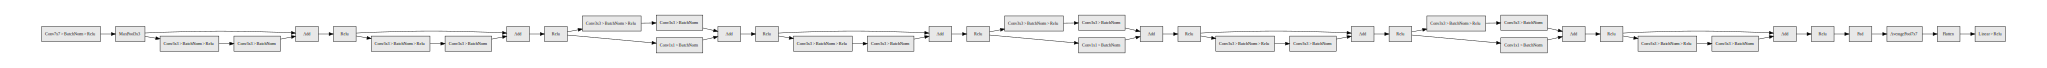

In [32]:
import hiddenlayer as hl
model = ResNet()

# Build HiddenLayer graph
# Jupyter Notebook renders it automatically
hl.build_graph(model, torch.zeros([3, 1, 224, 224]))

In [33]:
!pip install torchviz

  Created wheel for torchviz: filename=torchviz-0.0.2-cp37-none-any.whl size=4152 sha256=81d3442f0aa4311b216018cd88febc3d8e093849177016a3ba93ed122482bab6
  Stored in directory: /root/.cache/pip/wheels/01/26/58/026ffd533dbe8b3972eb423da9c7949beca68d1c98ed9e8624
Successfully built torchviz


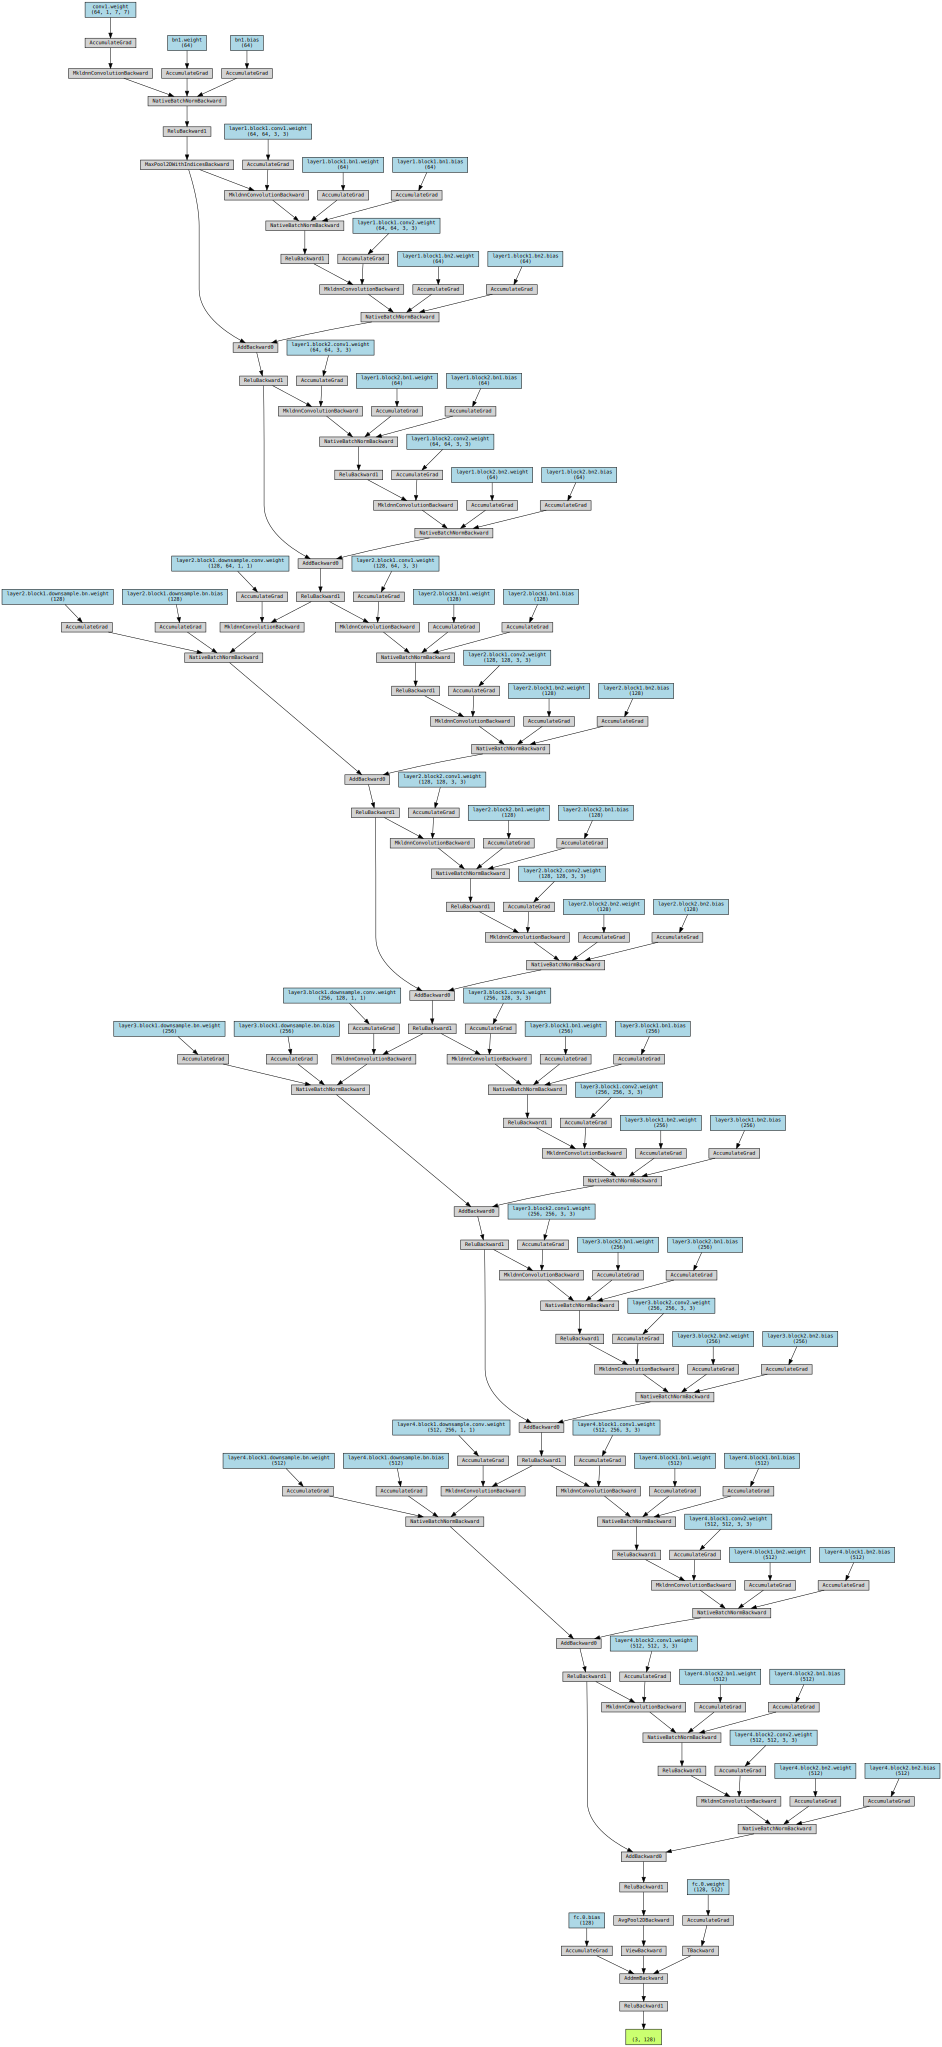

In [34]:
from torchviz import make_dot

x = torch.randn(3,1,224,224)

make_dot(model(x), params=dict(model.named_parameters()))   

# ref : https://github.com/szagoruyko/pytorchviz/blob/master/examples.ipynb